# SELFIES Tutorial

## The Basics

**1. How to Use SELFIES:** 

In [1]:
import selfies as sf

benzene = "c1ccccc1"

# SMILES --> SELFIES translation
encoded_selfies = sf.encoder(benzene)  # '[C][=C][C][=C][C][=C][Ring1][Branch1_2]'

# SELFIES --> SMILES translation
decoded_smiles = sf.decoder(encoded_selfies)  # 'C1=CC=CC=C1'

print('Input molecules:  ', benzene)
print('Encoded molecule: ', encoded_selfies)
print('Decoded molecule: ', decoded_smiles)

Input molecules:   c1ccccc1
Encoded molecule:  [C][=C][C][=C][C][=C][Ring1][Branch1_2]
Decoded molecule:  C1=CC=CC=C1


**2. Valid alphabets & random molecule:**

In [2]:
robust_alphabets = list(sf.get_semantic_robust_alphabet())
print('Num Chars: ', len(robust_alphabets))
print('Robust Alphabets: \n', robust_alphabets)

Num Chars:  61
Robust Alphabets: 
 ['[N+1expl]', '[=O]', '[=P-1expl]', '[#S+1expl]', '[O]', '[N-1expl]', '[P+1expl]', '[Branch3_3]', '[Expl=Ring2]', '[#S]', '[#N+1expl]', '[#P-1expl]', '[Ring2]', '[Branch2_2]', '[#S-1expl]', '[#C-1expl]', '[=P+1expl]', '[=P]', '[Branch2_3]', '[Expl=Ring3]', '[=O+1expl]', '[N]', '[Branch1_2]', '[Branch3_2]', '[#P]', '[Branch3_1]', '[Cl]', '[F]', '[Ring1]', '[#O+1expl]', '[S-1expl]', '[C+1expl]', '[=N-1expl]', '[O-1expl]', '[P]', '[#P+1expl]', '[S+1expl]', '[Branch1_3]', '[=S-1expl]', '[P-1expl]', '[=N+1expl]', '[Br]', '[C-1expl]', '[=S]', '[#C+1expl]', '[=N]', '[#N]', '[=C+1expl]', '[S]', '[Branch2_1]', '[=C-1expl]', '[Hexpl]', '[O+1expl]', '[Branch1_1]', '[C]', '[I]', '[Ring3]', '[=S+1expl]', '[=C]', '[#C]', '[Expl=Ring1]']


In [3]:
import random 
import numpy as np 


def get_random_smiles(num_random): 

    alphabet = list(sf.get_semantic_robust_alphabet()) 
    max_smi_len = 81
    collect_random = []
    
    for _ in range(num_random): 
        random_len = random.randint(1, max_smi_len+1)
        random_alphabets = list(np.random.choice(alphabet, random_len)) # + ['[C][=C][C][=C][C][=C][Ring1][Branch1_2]'] * 10 
        random_selfies = ''.join(x for x in random_alphabets)
        
        collect_random.append(sf.decoder(random_selfies))
    
    return [x for x in collect_random if x != '']

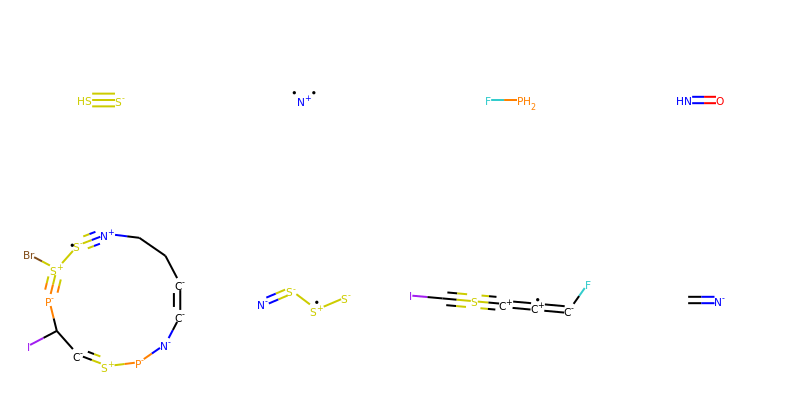

In [4]:
random_smiles = get_random_smiles(8)

from rdkit import Chem 
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smi) for smi in random_smiles]
img = Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(200,200))    
img

**3. One-Hot encoding for machine learning** 

In [5]:
import selfies as sf

dataset = ['[C][O][C]', '[F][C][F]', '[O][=O]', '[C][C][O][C][C]']
alphabet = sf.get_alphabet_from_selfies(dataset)
alphabet.add('[nop]')  # '[nop]' is a special padding symbol
alphabet = list(sorted(alphabet))
print(alphabet)  # ['[=O]', '[C]', '[F]', '[O]', '[nop]']

pad_to_len = max(sf.len_selfies(s) for s in dataset)  # 5
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

# SELFIES to label encode
dimethyl_ether = dataset[0]  # '[C][O][C]'

# [1, 3, 1, 4, 4]
print(sf.selfies_to_encoding(dimethyl_ether,
                             vocab_stoi=symbol_to_idx,
                             pad_to_len=pad_to_len,
                             enc_type='label'))
                             
# [[0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]
print(sf.selfies_to_encoding(dimethyl_ether,
                             vocab_stoi=symbol_to_idx,
                             pad_to_len=pad_to_len,
                             enc_type='one_hot'))

['[=O]', '[C]', '[F]', '[O]', '[nop]']
[1, 3, 1, 4, 4]
[[0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]


## Generating Molecules with STONED-SELFIES

**1. Random Mutations**

Randomized molecules (in SELFIES) time:  0.12917256355285645
Mutation obtainment time (back to smiles):  9.02753472328186
Unique mutated structure obtainment time:  0.9617328643798828
Fingerprint calculation time:  0.866302490234375


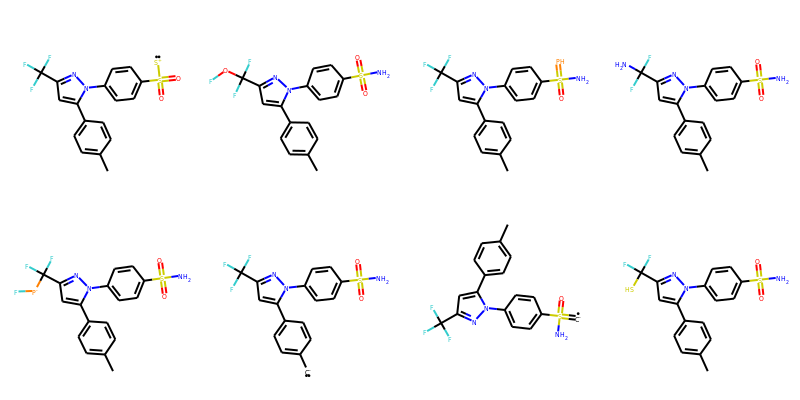

In [6]:
import time
from mutate_mols import get_mutated_mols, get_fp_scores

smi     = 'CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F'   # Celecoxib
fp_type = 'ECFP4'

num_random_samples = 1000     
num_mutation_ls    = [1, 2, 3, 4, 5]


canon_smi_ls = get_mutated_mols(smi, num_random_samples, num_mutation_ls, fp_type)


start_time = time.time()
canon_smi_ls_scores = get_fp_scores(canon_smi_ls, target_smi=smi, fp_type=fp_type)
print('Fingerprint calculation time: ', time.time()-start_time)

# Molecules with fingerprint similarity > 0.8
indices_thresh_8 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.8]
mols_8 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_8]

img = Draw.MolsToGridImage(mols_8[:8],molsPerRow=4,subImgSize=(200,200))    
img

In [7]:
len(canon_smi_ls)

4726

**2. Random Mutations with Filters**

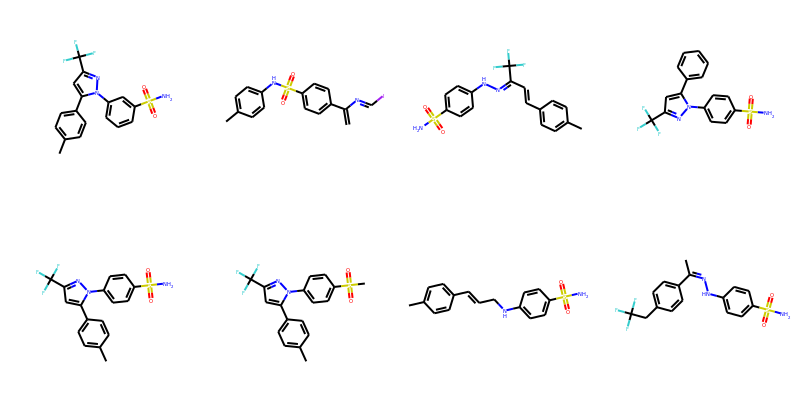

In [8]:
import numpy as np 
from syba.syba import SybaClassifier

syba = SybaClassifier()
syba.fitDefaultScore()

syba_scores = []
for item in canon_smi_ls: 
    syba_scores.append(syba.predict(smi=item))
        
A = np.argsort(syba_scores)
smi_arranged = [canon_smi_ls[i] for i in A]
smi_arranged = smi_arranged[-8:]
mols_        = [Chem.MolFromSmiles(x) for x in smi_arranged]

img=Draw.MolsToGridImage(mols_, molsPerRow=4, subImgSize=(200,200))    
img

**3. Mutations while preserving substructures**

<img src="https://github.com/aspuru-guzik-group/stoned-selfies/blob/main/data/struct_pres.png?raw=True" width="250" />

Randomized molecules (in SELFIES) time:  0.013020515441894531
Mutation obtainment time (back to smiles):  4.347912073135376
Unique mutated structure obtainment time:  0.11803174018859863


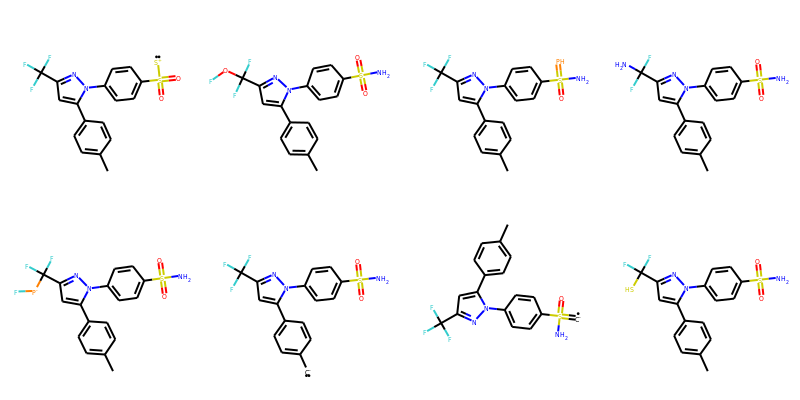

In [9]:
from mutate_mols import get_mutated_mols_substruct

smi     = 'CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F'   # Celecoxib


num_random_samples = 100     
num_mutation_ls    = [1, 2, 3, 4, 5]
mut_smiles = get_mutated_mols_substruct(smi, num_random_samples, num_mutation_ls)

mols = [Chem.MolFromSmiles(x) for x in mut_smiles]
img = Draw.MolsToGridImage(mols_8[:8],molsPerRow=4,subImgSize=(200,200))    
img


## Optimizing molecules with JANUS